# Optimization for a Kerr oscillator

In this example we will try to implement DRAG-like pulses on a Kerr oscillator, penalizing population going to leakage states. We will additionally use a slightly more complicated control scheme than in the qubit example. There we performed traditional grape, with piecewise-constant controls. Here we fit a spline to control knot points: it is these knot points that are optimized.

This technique has the benefit of ensuring smooth controls if the control points are spread far enough apart in time, which is not guaranteed in the case of piece-wise constant controls. It is important to emphasize here that the control points are in no way related to the points chosen by the numerical integrator for solving the differential equation! This is a significant difference from typical QOC/GRAPE implementations that perform numerical integration of the Schrödinger equation by calculating step propagators with sufficiently small time steps.

Here we will also batch over multiple random starting initial conditions to obtain multiple candidate pulses. The plotter will at each plotting step plot the best current solution. This is not to be confused with the batching we did in the qubit example where we batched over multiple random frequencies and optimized for all trajectories to achieve the gate. 

This example is available as a Jupyter notebook [here](https://github.com/dkweiss31/qontrol/blob/main/docs/examples/Kerr_oscillator.ipynb).

In [1]:
import diffrax as dx
import dynamiqs as dq
import jax
import jax.numpy as jnp
import optax
from jax import Array

import qontrol as ql

In [2]:
time = 20.0  # 20 ns pulse
control_dt = 2.0  # 2 ns timesteps
ramp_nts = 4  # cosine envelope takes 4 timesteps
n_batch = 10  # 10 random pulse seeds to optimize over simultaneously
ntimes = int(time // control_dt) + 1
tsave_control = jnp.linspace(0, time, ntimes)
tsave_plot = jnp.linspace(0.0, time, ntimes * 10)
optimizer = optax.adam(learning_rate=0.001, b1=0.999, b2=0.999)
# notice that 'batch' is set to True here to indicate that the leading dimension
# of the parameters is a batch dimension
opt_options = {
    'verbose': False,
    'epochs': 1000,
    'plot': True,
    'plot_period': 10,
    'batch_initial_parameters': True,
}
dq_options = dq.Options(save_states=True, progress_meter=False)

We define our Kerr oscillator to have a 100 MHz Kerr. We optimize the drive envelopes on the I and Q quadratures.

In [3]:
dim = 5
Kerr = -2.0 * jnp.pi * 0.100
a = dq.destroy(dim)
H0 = 0.5 * Kerr * dq.dag(a) @ dq.dag(a) @ a @ a
H1s = [a + dq.dag(a), 1j * (a - dq.dag(a))]
H1_labels = ['I', 'Q']

Here we attempt to perform an `X` gate, and penalize population leaking to the higher-lying states

In [4]:
initial_states = [dq.basis(dim, 0), dq.basis(dim, 1)]
final_states = [dq.basis(dim, 1), dq.basis(dim, 0)]
_forbidden_states = [dq.basis(dim, idx) for idx in range(2, dim)]
forbidden_states_list = len(initial_states) * [_forbidden_states]

We initialize the guess for the controls and moreover define an envelope of cosine ramps with a flat top to ensure that the control turns on slowly. 

In [5]:
key = jax.random.key(31)
# notice that the leading dimension is of n_batch, setting how many pulses to optimize
init_drive_params = 0.001 * jax.random.uniform(key, (n_batch, len(H1s), ntimes))

cos_ramp = (1 - jnp.cos(jnp.linspace(0.0, jnp.pi, ramp_nts))) / 2
envelope = jnp.concatenate(
    (cos_ramp, jnp.ones(ntimes - 2 * ramp_nts), jnp.flip(cos_ramp))
)


def _drive_spline(
    drive_params: Array, envelope: Array, ts: Array
) -> dx.CubicInterpolation:
    drive_w_envelope = jnp.einsum('t,...t->t...', envelope, drive_params)
    drive_coeffs = dx.backward_hermite_coefficients(ts, drive_w_envelope)
    return dx.CubicInterpolation(ts, drive_coeffs)


def H_func(drive_params: Array) -> dq.TimeQArray:
    H = dq.constant(H0)
    H += dq.modulated(
        _drive_spline(drive_params[0], envelope, tsave_control).evaluate, H1s[0]
    )
    H += dq.modulated(
        _drive_spline(drive_params[1], envelope, tsave_control).evaluate, H1s[1]
    )
    return H


exp_ops = [dq.basis(dim, idx) @ dq.dag(dq.basis(dim, idx)) for idx in range(dim)]

se_Kerr_model = ql.sesolve_model(H_func, initial_states, tsave_plot, exp_ops=exp_ops)

In [6]:
costs = ql.coherent_infidelity(target_states=final_states, target_cost=0.005)
costs += 0.01 * ql.forbidden_states(
    forbidden_states_list=forbidden_states_list, target_cost=0.4
)

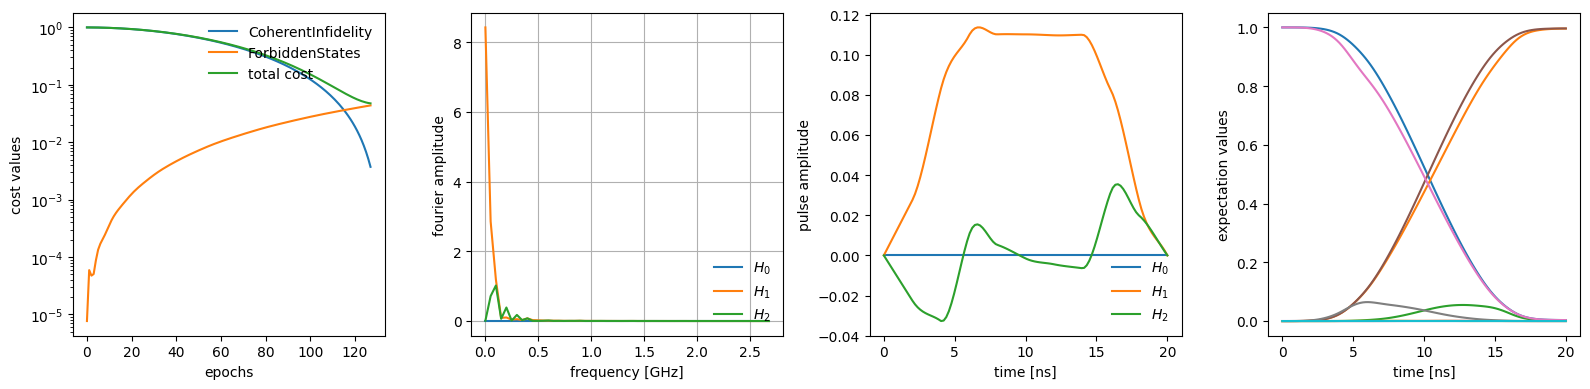

target cost reached for all cost functions
optimization terminated after 127 epochs
average epoch time (excluding jit) of 0.00826 s
max epoch time of 0.02681 s
min epoch time of 0.00623 s


In [7]:
opt_params = ql.optimize(
    init_drive_params,
    costs,
    model=se_Kerr_model,
    optimizer=optimizer,
    opt_options=opt_options,
    dq_options=dq_options,
)

Try playing with the `cost_multiplier` of the forbidden states cost function to see how it modifies the pulse! Specifically, try setting it to 0 so that the optimizer is happy to populate the 2nd excited state without penalty.

## Master-equation optimization

We can also instead perform the optimization directly on the master equation. Continuing the above example, we need now to initialize an `mesolve_model`, which calls `dq.mesolve`, and to correctly specify the initial and target states as density matrices.

In [8]:
jump_ops = [0.01 * a]
me_initial_states = dq.todm(initial_states)
me_final_states = dq.todm(final_states)
me_forbidden_states_list = len(initial_states) * [dq.todm(_forbidden_states)]
me_costs = ql.coherent_infidelity(target_states=me_final_states, target_cost=0.005)
me_costs += 0.01 * ql.forbidden_states(
    forbidden_states_list=me_forbidden_states_list, target_cost=0.4
)

me_Kerr_model = ql.mesolve_model(
    H_func, jump_ops, me_initial_states, tsave_plot, exp_ops=exp_ops
)

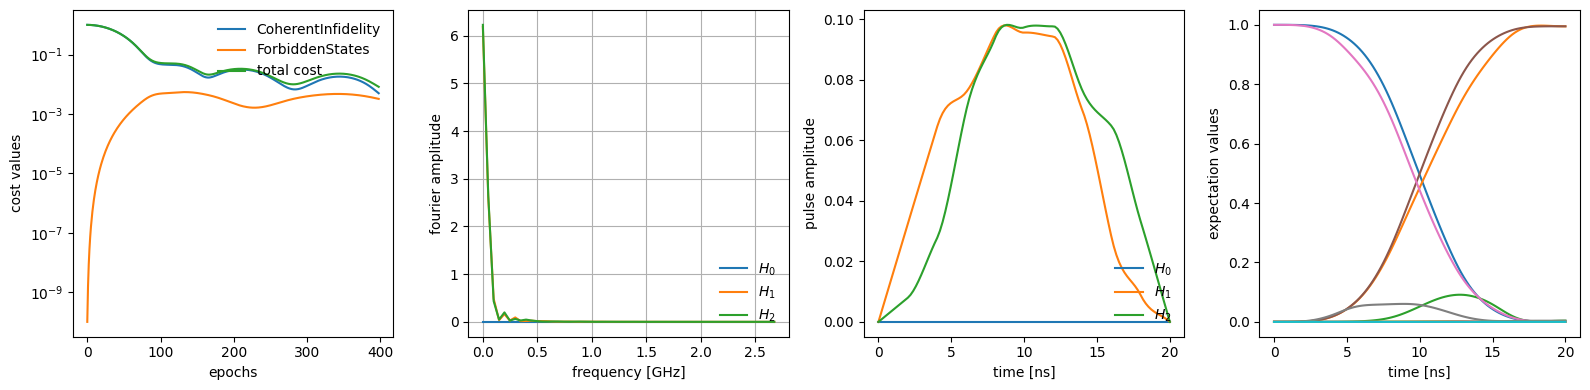

target cost reached for all cost functions
optimization terminated after 398 epochs
average epoch time (excluding jit) of 0.01613 s
max epoch time of 0.04582 s
min epoch time of 0.01321 s


In [9]:
opt_params_me = ql.optimize(
    init_drive_params,
    me_costs,
    me_Kerr_model,
    optimizer=optimizer,
    opt_options=opt_options,
    dq_options=dq_options,
)